<a href="https://colab.research.google.com/github/LennartReddm/productionvspredation/blob/main/Behavioral_Analysis_Production_vs_Predation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & Data Processing

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
from google.colab import data_table

In [ ]:
# "Downgrade" R
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

In [ ]:
# Install and load R packages
%%R
install.packages("lme4")
install.packages("lmerTest")
library(lme4)
library(lmerTest)

In [ ]:
## Data processing

# Load experimental data into panda dataframe.
complete = pd.read_excel(r'/content/complete.xlsx')

# Create columns for conflict variables
# We create an additional column with '1' if conflict investment > 0 and '0' if conflict investment = 0.
complete['conflict_y_n'] = np.where(complete['conflict']>=1, 1, 0)
# Based on that we calculate the average frequency of conflict investment for each pp and put in into the newly create column 'conflict_freq'.
complete['conflict_freq'] = complete.groupby('ID')['conflict_y_n'].transform('mean')
complete['conflict_force'] = complete.groupby('ID')['conflict'].transform('mean')
# Create columns for production variables
# We create an additional column with '1' if production investment > 0 and '0' if conflict investment = 0.
complete['innovation_y_n'] = np.where(complete['innovation']>=1, 1, 0)
# Based on that we calculate the average frequency of production investment for each pp and put in into the newly create column 'production_freq'.
complete['innovation_freq'] = complete.groupby('ID')['innovation_y_n'].transform('mean')
# Production magnitude
complete['innovation_force'] = complete.groupby('ID')['innovation'].transform('mean')
# Production success
complete['inno_success_rate'] = complete.groupby('ID')['prize'].transform('mean')
# Column with avg production bu subject
complete['avg_innovation'] = complete.groupby('ID')['innovation'].transform('mean')
# Based on that, we create an additional column with the return on investment for production
complete["inno_invest_effic"] = ((complete["inno_success_rate"] * 30) / complete["avg_innovation"])

# Drop unnecessary columns
complete_m = complete
# Remove columns we don't need
complete_m = complete_m.drop(columns=complete_m.columns[2:5])

# Remove case with faulty data recording
complete_m = complete_m[complete_m['conflict'] != 30]

# Create dataframe with only first round per subject
complete_m_oner = complete_m.drop_duplicates(subset=['ID'])

# Create data frame with separate attacker and defender variables
complete_att = complete[complete['role'] == 'attacker']
complete_def = complete[complete['role'] == 'defender']
# Merge dataframes
complete_wide = pd.merge(complete_att, complete_def, on=['group','round'])
# Rename columns
complete_wide.columns = [col.replace('_x', '_att').replace('_y', '_def') for col in complete_wide.columns]
# Remove original dataframes
del complete_att, complete_def

# Bring relevant columns to front
cols = list(complete_wide)
cols.insert(0, cols.pop(cols.index("group")))
cols.insert(1, cols.pop(cols.index("round")))
cols.insert(2, cols.pop(cols.index("treatment_att")))
cols.insert(3, cols.pop(cols.index("conflict_att")))
cols.insert(4, cols.pop(cols.index("conflict_def")))
cols.insert(5, cols.pop(cols.index("innovation_att")))
cols.insert(6, cols.pop(cols.index("innovation_def")))
cols.insert(7, cols.pop(cols.index("earnings_after_att")))
cols.insert(8, cols.pop(cols.index("earnings_after_def")))
complete_wide = complete_wide.loc[:, cols]

# Remove columns we don't need
complete_wide = complete_wide.iloc[:,:9]

# Create Earnings Inequality variable
complete_wide['earnings_ineq'] = complete_wide['earnings_after_att'] - complete_wide['earnings_after_def']

# Create data frame for cross-round analysis
complete_wide_cr = complete_wide
# create a list of values to exclude for cross-round analysis
peaceful = [41, 55, 91, 107, 111, 129, 131]
# exclude rows with values in the exclude list
complete_wide_cr = complete_wide_cr[~complete_wide_cr['group'].isin(peaceful)]
# Create 'confl_att_lag_1' variable
complete_wide_cr.loc[:, 'confl_att_lag_1'] = complete_wide_cr.groupby(['group'])['conflict_att'].shift(1)
# Create 'confl_def_lag_1' variable
complete_wide_cr.loc[:, 'confl_def_lag_1'] = complete_wide_cr.groupby(['group'])['conflict_def'].shift(1)

# We create data frames with mean values by subject ordered by dyad, treatment, and role for the swarmplots 
# Conflict
completebysubjCI = complete[['group', 'treatment', 'role', 'conflict']].groupby(['group', 'treatment', 'role' ])['conflict'].mean().to_frame().reset_index()
# Earnings 
completebysubjPO = complete[['group', 'treatment', 'role', 'earnings_after']].groupby(['group', 'treatment', 'role' ])['earnings_after'].mean().to_frame().reset_index()
# Production
completebysubjPI = complete[['group', 'treatment', 'role', 'innovation']].groupby(['group', 'treatment', 'role' ])['innovation'].mean().to_frame().reset_index()

# Function that takes the outcome variable and equilibrium values and returns a summary data frame with mean values.
def create_sum_df(outcome_var, equilibrium_values):
  # Create data frame with mean value for condition and role
  avgInv = complete.groupby(['treatment', 'role'])[outcome_var].mean()
  avgInv = avgInv.to_frame()
  # Add the equilibrium predictions
  avgInv.insert(0, 'Equilibrium', equilibrium_values)
  avgInv = avgInv.reset_index()
  # Rename columns
  avgInv = avgInv.rename(columns={"treatment": "Treatment", "role": "Role", 'Observed': outcome_var})
  return avgInv

# We create summary data frame with mean values for conflict, conflict frequency, earnings, and production,
outcome_var = 'conflict'
equilibriumCol = [4.961,
                  7.039, 
                  4.896, 
                  5.791]
avgCInv = create_sum_df(outcome_var, equilibriumCol)

outcome_var = 'conflict_freq'
equilibriumCol = [0.600,
                  0.950,
                  0.672,
                  0.970]
avgCFreq = create_sum_df(outcome_var, equilibriumCol)

outcome_var = 'earnings_after'
equilibriumCol = [20,
                  8, 
                  33.484, 
                  11.000]
payoff = create_sum_df(outcome_var, equilibriumCol)

outcome_var = 'innovation'
equilibriumCol  = ['NA',
                   'NA',
                    8.951, 
                    12.684]
avgPInv = create_sum_df(outcome_var, equilibriumCol)

# Figure 4

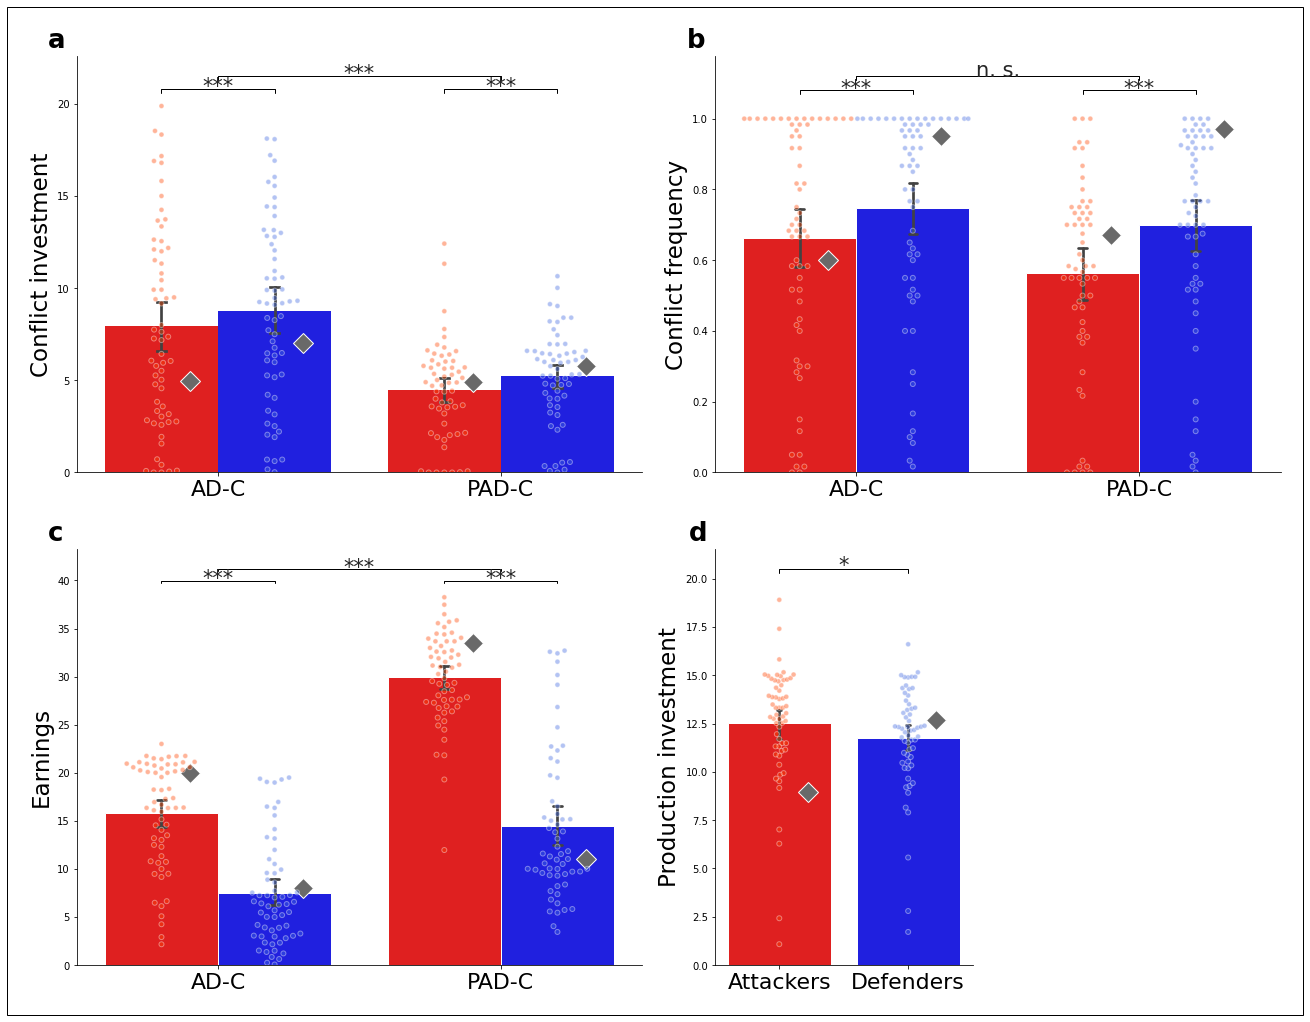

In [7]:
# We create a combined plot with behavioral data and game-theoretic benchmarks for attackers (red) and defenders (blue) 
# in the Attacker-Defender Contest (AD-C) and the implemented Production Attacker-Defender Contest (PAD-C). 
# Shown are mean values (bars), standard errors (± 1 SE), aggregated investment by subject (dots), 
# and Nash equilibrium predictions (Diamonds). 

# Set up the figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))

rect = plt.Rectangle(
    # (lower-left corner), width, height
    (0, 0), 1, 1, fill=False, color="k", lw=1, 
    zorder=1000, transform=fig.transFigure, figure=fig
)
fig.patches.extend([rect])
plt.rc('font', size=21)  

axs = axs.flatten()
axs[0].annotate('a', xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=26, weight = 'bold')
axs[1].annotate('b', xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=26, weight = 'bold')
axs[2].annotate('c', xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=26, weight = 'bold')
axs[3].annotate('d', xy=(-0.1, 1.02), xycoords="axes fraction", fontsize=26, weight = 'bold')

sns.barplot(x="treatment",
            y="conflict", 
            hue="role", 
            palette=sns.color_palette(['red', 'blue']),
            order=['control', 'experimental'],
            hue_order=['attacker', 'defender'],
            alpha=1,
            capsize=.03,
            ax=axs[0],
            data=completebysubjCI)
sns.swarmplot(x="treatment", 
              y="conflict", 
              hue="role", 
              data=completebysubjCI,
              palette=sns.color_palette(['orangered', 'royalblue']),
              order=['control', 'experimental'],
              hue_order=['attacker', 'defender'],
              edgecolor='white',
              linewidth=1, 
              dodge=True,
              ax=axs[0],
              alpha=0.4).set(xticklabels=['AD-C', 'PAD-C'], ylabel='Conflict investment', xlabel='')

sns.set_style('white')
sns.despine()

height = 21.5
axs[0].plot([0,0, 1, 1], [height-0.2, height, height, height-0.2], linewidth=1, color='k')
axs[0].plot([-0.2,-0.2, 0.2, 0.2], [height-0.9, height-0.7, height-0.7, height-0.9], linewidth=1, color='k')
axs[0].plot([0.8,0.8, 1.2, 1.2], [height-0.9, height-0.7, height-0.7, height-0.9], linewidth=1, color='k')
axs[0].text(0.5, height+0.15, '***', horizontalalignment='center', verticalalignment='center')
axs[0].text(0, height-0.55, '***', horizontalalignment='center', verticalalignment='center')
axs[0].text(1, height-0.55, '***', horizontalalignment='center', verticalalignment='center')

axs[0].plot([-0.1], avgCInv['Equilibrium'][0], marker='D', linestyle="None", markerfacecolor='dimgrey',markersize=14, markeredgecolor='white')
axs[0].plot([0.3], avgCInv['Equilibrium'][1], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[0].plot([0.9], avgCInv['Equilibrium'][2], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[0].plot([1.3], avgCInv['Equilibrium'][3], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')

sns.barplot(x="treatment",
            y="conflict_freq", 
            hue="role", 
            palette=sns.color_palette(['red', 'blue']),
            order=['control', 'experimental'],
            hue_order=['attacker', 'defender'],
            alpha=1,
            capsize=.03,
            ax=axs[1],
            data=complete_m_oner)
sns.swarmplot(x="treatment", 
              y="conflict_freq", 
              hue="role", 
              data=complete_m_oner,
              palette=sns.color_palette(['orangered', 'royalblue']),
              order=['control', 'experimental'],
              hue_order=['attacker', 'defender'],
              edgecolor='white',
              linewidth=1, 
              dodge=True,
              ax=axs[1],
              alpha=0.4).set(xticklabels=['AD-C', 'PAD-C'], ylabel='Conflict frequency', xlabel='')

sns.set_style('white')
sns.despine()

height = 1.12
axs[1].plot([0,0, 1, 1], [height-0.01, height, height, height-0.01], linewidth=1, color='k')
axs[1].plot([-0.2,-0.2, 0.2, 0.2], [height-0.05, height-0.04, height-0.04, height-0.05], linewidth=1, color='k')
axs[1].plot([0.8,0.8, 1.2, 1.2], [height-0.05, height-0.04, height-0.04, height-0.05], linewidth=1, color='k')
axs[1].text(0.5, height+0.015, 'n. s.', horizontalalignment='center', verticalalignment='center')
axs[1].text(0, height-0.035, '***', horizontalalignment='center', verticalalignment='center')
axs[1].text(1, height-0.035, '***', horizontalalignment='center', verticalalignment='center')

axs[1].plot([-0.1], avgCFreq['Equilibrium'][0], marker='D', linestyle="None", markerfacecolor='dimgrey',markersize=14, markeredgecolor='white')
axs[1].plot([0.3], avgCFreq['Equilibrium'][1], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[1].plot([0.9], avgCFreq['Equilibrium'][2], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[1].plot([1.3], avgCFreq['Equilibrium'][3], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')

sns.barplot(x="treatment",
            y="earnings_after", 
            hue="role", 
            palette=sns.color_palette(['red', 'blue']),
            order=['control', 'experimental'],
            hue_order=['attacker', 'defender'],
            alpha=1,
            capsize=.03,
            ax=axs[2],
            data=completebysubjPO)
sns.swarmplot(x="treatment", 
              y="earnings_after", 
              hue="role", 
              data=completebysubjPO,
              palette=sns.color_palette(['orangered', 'royalblue']),
              order=['control', 'experimental'],
              hue_order=['attacker', 'defender'],
              edgecolor='white',
              linewidth=1, 
              dodge=True,
              ax=axs[2],
              alpha=0.4).set(xticklabels=['AD-C', 'PAD-C'], ylabel='Earnings', xlabel='')

sns.set_style('white')
sns.despine()

height = 41.2
axs[2].plot([0,0, 1, 1], [height-0.2, height, height, height-0.2], linewidth=1, color='k')
axs[2].plot([-0.2,-0.2, 0.2, 0.2], [height-1.5, height-1.3, height-1.3, height-1.5], linewidth=1, color='k')
axs[2].plot([0.8,0.8, 1.2, 1.2], [height-1.5, height-1.3, height-1.3, height-1.5], linewidth=1, color='k')
axs[2].text(0.5, height+0.15, '***', horizontalalignment='center', verticalalignment='center')
axs[2].text(0, height-1, '***', horizontalalignment='center', verticalalignment='center')
axs[2].text(1, height-1, '***', horizontalalignment='center', verticalalignment='center')

axs[2].plot([-0.1], payoff['Equilibrium'][0], marker='D', linestyle="None", markerfacecolor='dimgrey',markersize=14, markeredgecolor='white')
axs[2].plot([0.3], payoff['Equilibrium'][1], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[2].plot([0.9], payoff['Equilibrium'][2], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[2].plot([1.3], payoff['Equilibrium'][3], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')

sns.barplot(x="role",
            y="innovation", 
            palette=sns.color_palette(['red', 'blue']),
            order=['attacker', 'defender'],
            alpha=1,
            capsize=.03,
            ax=axs[3],
            data=completebysubjPI[completebysubjPI.treatment=="experimental"])
sns.swarmplot(x="role",
              y="innovation", 
              data=completebysubjPI[completebysubjPI.treatment=="experimental"],
              palette=sns.color_palette(['orangered', 'royalblue']),
              order=['attacker', 'defender'],
              edgecolor='white',
              linewidth=1, 
              dodge=True,
              ax=axs[3],
              alpha=0.4).set(xticklabels=['Attackers', 'Defenders'], ylabel='Production investment', xlabel='')

sns.set_style('white')
sns.despine()

height = 20.5
axs[3].plot([0,0, 1, 1], [height-0.2, height, height, height-0.2], linewidth=1, color='k')
axs[3].text(0.5, height+0.15, '*', horizontalalignment='center', verticalalignment='center')

axs[3].plot([0.22], avgPInv['Equilibrium'][2], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[3].plot([1.22], avgPInv['Equilibrium'][3], marker='D', linestyle="None", markerfacecolor='dimgrey', markersize=14, markeredgecolor='white')
axs[3].set_aspect(0.15)
axs[3].set_anchor('W', share=False)

axs[0].yaxis.label.set_size(23)
axs[1].yaxis.label.set_size(23)
axs[2].yaxis.label.set_size(23)
axs[3].yaxis.label.set_size(23)
axs[0].tick_params(axis='x', which='major', labelsize=22)
axs[1].tick_params(axis='x', which='major', labelsize=22)
axs[2].tick_params(axis='x', which='major', labelsize=22)
axs[3].tick_params(axis='x', which='major', labelsize=22)

plt.plot([],[], marker="D", linestyle="None", markerfacecolor='dimgrey', markersize=12, markeredgecolor='white')

axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].get_legend().remove()

plt.tight_layout()
plt.show()

# Mixed Models

## Conflict variables

### Conflict investment

In [8]:
## Conflict investment
%%R -i complete_m

m1 <- lmer(conflict ~ 1 + treatment*role + (1 | group/ID), data=complete_m)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: conflict ~ 1 + treatment * role + (1 | group/ID)
   Data: complete_m

REML criterion at convergence: 85852.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4778 -0.6338 -0.0286  0.4886  4.0406 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID:group (Intercept)  1.463   1.209   
 group    (Intercept) 15.145   3.892   
 Residual             22.739   4.769   
Number of obs: 14279, groups:  ID:group, 242; group, 121

Fixed effects:
                                    Estimate Std. Error        df t value
(Intercept)                          7.94167    0.52343 132.55018  15.172
treatmentexperimental               -3.48101    0.74981 132.69749  -4.643
roledefender                         0.81640    0.24374 117.73616   3.349
treatmentexperimental:roledefender  -0.04602    0.34992 118.79969  -0.132
                                   Pr(>|t|)    
(Intercept)               

### Conflict magnitude

In [9]:
# Conflict magnitude
%%R -i complete_m_oner
m1 <- lmer(conflict_force ~ 1 + treatment*role + (1 | group), data=complete_m_oner)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: conflict_force ~ 1 + treatment * role + (1 | group)
   Data: complete_m_oner

REML criterion at convergence: 1178.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9150 -0.3809 -0.0214  0.3509  4.4452 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 15.125   3.889   
 Residual              1.854   1.362   
Number of obs: 242, groups:  group, 121

Fixed effects:
                                    Estimate Std. Error        df t value
(Intercept)                          7.94167    0.52332 132.69767  15.176
treatmentexperimental               -3.46879    0.74943 132.69767  -4.629
roledefender                         0.81640    0.24455 119.00001   3.338
treatmentexperimental:roledefender  -0.06145    0.35021 119.00001  -0.175
                                   Pr(>|t|)    
(Intercept)                         < 2e-16 ***
treatmentexperimental       

### Conflict frequency

In [10]:
# Conflict frequency
%%R -i complete_m_oner
m1 <- lmer(conflict_freq ~ 1 + treatment*role + (1 | group), data=complete_m_oner)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: conflict_freq ~ 1 + treatment * role + (1 | group)
   Data: complete_m_oner

REML criterion at convergence: -35.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.22858 -0.42873 -0.02895  0.55160  2.22134 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 0.07515  0.2741  
 Residual             0.01348  0.1161  
Number of obs: 242, groups:  group, 121

Fixed effects:
                                    Estimate Std. Error        df t value
(Intercept)                          0.66344    0.03781 138.45857  17.547
treatmentexperimental               -0.09889    0.05414 138.45857  -1.826
roledefender                         0.08333    0.02085 119.00000   3.996
treatmentexperimental:roledefender   0.05169    0.02986 119.00000   1.731
                                   Pr(>|t|)    
(Intercept)                         < 2e-16 ***
treatmentexperimenta

### Attacker victory rate

In [11]:
%%R -i complete_m

# Only one attack success/failure per dyad
completeAtt <- (complete_m[complete_m$role == "attacker",])

m1 <- lmer(attackwin ~ 1 + treatment + (1 | ID), data=completeAtt)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: attackwin ~ 1 + treatment + (1 | ID)
   Data: completeAtt

REML criterion at convergence: 8450.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8814 -0.7915 -0.4539  1.2907  2.2117 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.02065  0.1437  
 Residual             0.18453  0.4296  
Number of obs: 7139, groups:  ID, 121

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)             0.30376    0.01956 118.45432  15.529   <2e-16 ***
treatmentexperimental  -0.03069    0.02806 119.17447  -1.094    0.276    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
trtmntxprmn -0.697


## Production variables

### Production investment

In [12]:
complete_m

subject  group  round     treatment      role  nature  \
0            1      1      1  experimental  defender    15.0   
1            2      1      1  experimental  attacker    15.0   
2            1      1      2  experimental  defender    13.0   
3            2      1      2  experimental  attacker    13.0   
4            1      1      3  experimental  defender    12.0   
...        ...    ...    ...           ...       ...     ...   
14275        2    162     58       control  attacker     NaN   
14276        1    162     59       control  defender     NaN   
14277        2    162     59       control  attacker     NaN   
14278        1    162     60       control  defender     NaN   
14279        2    162     60       control  attacker     NaN   

                      date     RT  conflict  innovation  ...  attackwin  \
0      2019_02_25_10_03_30   8.16         0        20.0  ...       True   
1      2019_02_25_10_19_55  42.46        10         8.0  ...       True   
2      2019_02_25_10_20_19   5.38         0        20.0  ...       True   
3      2019_02_25_10_21_26  36.92        10        10.0  ...       True   
4      2019_02_25_10_21_51   9.50        15         0.0  ...       True   
...                    ...    ...       ...         ...  ...        ...   
14275  2019_03_13_13_29_37   3.85        10         NaN  ...      False   
14276  2019_03_13_13_29_45   3.62        10         NaN  ...      False   
14277  2019_03_13_13_29_48   6.68         5         NaN  ...      False   
14278  2019_03_13_13_29_58   6.70        10         NaN  ...      False   
14279  2019_03_13_13_29_59   6.71         5         NaN  ...      False   

      conflict_y_n  conflict_freq  conflict_force  innovation_y_n  \
0                0          0.400        6.975000               1   
1                1          0.675       11.325000               1   
2                0          0.400        6.975000               1   
3                1          0.675       11.325000               1   
4                1          0.400        6.975000               0   
...            ...            ...             ...             ...   
14275            1          1.000        9.400000               0   
14276            1          1.000       12.783333               0   
14277            1          1.000        9.400000               0   
14278            1          1.000       12.783333               0   
14279            1          1.000        9.400000               0   

       innovation_freq  innovation_force  inno_success_rate  avg_innovation  \
0                0.625            11.225              0.575          11.225   
1                0.175             2.425              0.100           2.425   
2                0.625            11.225              0.575          11.225   
3                0.175             2.425              0.100           2.425   
4                0.625            11.225              0.575          11.225   
...                ...               ...                ...             ...   
14275            0.000               NaN                NaN             NaN   
14276            0.000               NaN                NaN             NaN   
14277            0.000               NaN                NaN             NaN   
14278            0.000               NaN                NaN             NaN   
14279            0.000               NaN                NaN             NaN   

       inno_invest_effic  
0               1.536748  
1               1.237113  
2               1.536748  
3               1.237113  
4               1.536748  
...                  ...  
14275                NaN  
14276                NaN  
14277                NaN  
14278                NaN  
14279                NaN  

[14279 rows x 26 columns]

In [13]:
## Innovation investment
%%R -i complete_m

complete_m_exp <- complete_m[complete_m$treatment == "experimental",]

m1 <- lmer(innovation ~ 1 + role + (1 | ID), data=complete_m_exp)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: innovation ~ 1 + role + (1 | ID)
   Data: complete_m_exp

REML criterion at convergence: 41022.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1544 -0.2137  0.1385  0.5231  3.3468 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  7.91    2.812   
 Residual             22.37    4.730   
Number of obs: 6839, groups:  ID, 118

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   12.5340     0.3751 115.7582  33.414   <2e-16 ***
roledefender  -0.7696     0.5305 115.7567  -1.451     0.15    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
roledefendr -0.707


### Production magnitude

In [14]:
## Production magnitude
%%R -i complete_m_oner

complete_m_oner_e <- complete_m_oner[complete_m_oner$treatment == "experimental",]

m1 <- lmer(innovation_force ~ 1 + role + (1 | group), data=complete_m_oner_e)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: innovation_force ~ 1 + role + (1 | group)
   Data: complete_m_oner_e

REML criterion at convergence: 553.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4200 -0.2240  0.1422  0.3723  2.0530 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 5.282    2.298   
 Residual             3.058    1.749   
Number of obs: 118, groups:  group, 59

Fixed effects:
             Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   12.5346     0.3760 82.7905  33.340   <2e-16 ***
roledefender  -0.7705     0.3220 58.0000  -2.393     0.02 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
roledefendr -0.428


### Production frequency

In [15]:
complete_m_oner

subject  group  round     treatment      role  nature  \
0            1      1      1  experimental  defender    15.0   
1            2      1      1  experimental  attacker    15.0   
80           1      3      1  experimental  defender    14.0   
81           2      3      1  experimental  attacker    14.0   
160          1      4      1       control  defender     NaN   
...        ...    ...    ...           ...       ...     ...   
13921        2    158      1       control  attacker     NaN   
14040        1    160      1       control  defender     NaN   
14041        2    160      1       control  attacker     NaN   
14160        1    162      1       control  defender     NaN   
14161        2    162      1       control  attacker     NaN   

                      date     RT  conflict  innovation  ...  attackwin  \
0      2019_02_25_10_03_30   8.16         0        20.0  ...       True   
1      2019_02_25_10_19_55  42.46        10         8.0  ...       True   
80     2019_02_25_12_05_40  17.17         0        10.0  ...       True   
81     2019_02_25_12_03_35   9.86        20         0.0  ...       True   
160    2019_02_25_12_15_25  17.37        15         NaN  ...      False   
...                    ...    ...       ...         ...  ...        ...   
13921  2019_03_13_11_20_08  11.06         5         NaN  ...       True   
14040  2019_03_13_13_07_06   9.10        10         NaN  ...      False   
14041  2019_03_13_13_04_09  10.31        10         NaN  ...      False   
14160  2019_03_13_13_12_17  10.62        15         NaN  ...      False   
14161  2019_03_13_13_19_46   9.31        10         NaN  ...      False   

      conflict_y_n  conflict_freq  conflict_force  innovation_y_n  \
0                0       0.400000        6.975000               1   
1                1       0.675000       11.325000               1   
80               0       0.725000        4.725000               1   
81               1       0.575000        4.725000               0   
160              1       1.000000       17.216667               0   
...            ...            ...             ...             ...   
13921            1       0.016667        0.083333               0   
14040            1       0.950000        5.266667               0   
14041            1       0.750000        3.333333               0   
14160            1       1.000000       12.783333               0   
14161            1       1.000000        9.400000               0   

       innovation_freq  innovation_force  inno_success_rate  avg_innovation  \
0                0.625            11.225              0.575          11.225   
1                0.175             2.425              0.100           2.425   
80               0.850            11.825              0.600          11.825   
81               0.825            12.525              0.775          12.525   
160              0.000               NaN                NaN             NaN   
...                ...               ...                ...             ...   
13921            0.000               NaN                NaN             NaN   
14040            0.000               NaN                NaN             NaN   
14041            0.000               NaN                NaN             NaN   
14160            0.000               NaN                NaN             NaN   
14161            0.000               NaN                NaN             NaN   

       inno_invest_effic  
0               1.536748  
1               1.237113  
80              1.522199  
81              1.856287  
160                  NaN  
...                  ...  
13921                NaN  
14040                NaN  
14041                NaN  
14160                NaN  
14161                NaN  

[242 rows x 26 columns]

In [16]:
## Innovation frequency
%%R -i complete_m_oner

complete_m_oner_e <- complete_m_oner[complete_m_oner$treatment == "experimental",]

m1 <- lmer(innovation_freq ~ 1 + role + (1 | group), data=complete_m_oner_e)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: innovation_freq ~ 1 + role + (1 | group)
   Data: complete_m_oner_e

REML criterion at convergence: -78.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4885 -0.1831  0.2537  0.3697  1.9395 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 0.01685  0.1298  
 Residual             0.01555  0.1247  
Number of obs: 118, groups:  group, 59

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   0.867514   0.023434 91.300768  37.019   <2e-16 ***
roledefender -0.006497   0.022958 58.000001  -0.283    0.778    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
roledefendr -0.490


### Production success rate

In [17]:
## Production success rate
%%R -i complete_m_oner

complete_m_oner <- complete_m_oner[complete_m_oner$treatment == "experimental",]

m1 <- lmer(inno_success_rate ~ 1 + role + (1 | group), data=complete_m_oner)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: inno_success_rate ~ 1 + role + (1 | group)
   Data: complete_m_oner

REML criterion at convergence: -78.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.07488 -0.36229  0.04215  0.52611  2.09551 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 0.02741  0.1656  
 Residual             0.01157  0.1076  
Number of obs: 118, groups:  group, 59

Fixed effects:
             Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   0.68037    0.02571 77.62080   26.47  < 2e-16 ***
roledefender -0.08121    0.01981 58.00000   -4.10  0.00013 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
roledefendr -0.385


### Production ROI

In [18]:
## Innovation investment
%%R -i complete_m

complete_m_exp <- complete_m[complete_m$treatment == "experimental",]

m1 <- lmer(inno_invest_effic ~ 1 + role + (1 | group), data=complete_m_exp)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: inno_invest_effic ~ 1 + role + (1 | group)
   Data: complete_m_exp

REML criterion at convergence: -7300.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3389 -0.5783  0.0299  0.5843  3.3101 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 0.05874  0.2424  
 Residual             0.01910  0.1382  
Number of obs: 6839, groups:  group, 59

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   1.589e+00  3.164e-02  5.833e+01   50.21   <2e-16 ***
roledefender -1.032e-01  3.343e-03  6.779e+03  -30.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
roledefendr -0.053


## Earning variables

### Earnings

In [19]:
# Conflict frequency
%%R -i complete_m
m1 <- lmer(earnings_after ~ 1 + treatment*role + (1 | ID), data=complete_m)
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: earnings_after ~ 1 + treatment * role + (1 | ID)
   Data: complete_m

REML criterion at convergence: 108337.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4165 -0.4969 -0.0121  0.4196  3.9518 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  33.9     5.822  
 Residual             109.9    10.485  
Number of obs: 14279, groups:  ID, 242

Fixed effects:
                                   Estimate Std. Error       df t value
(Intercept)                         15.8258     0.7591 237.3225  20.847
treatmentexperimental               14.0974     1.0879 237.9324  12.959
roledefender                        -8.3513     1.0736 237.3225  -7.779
treatmentexperimental:roledefender  -7.1004     1.5385 237.9306  -4.615
                                   Pr(>|t|)    
(Intercept)                         < 2e-16 ***
treatmentexperimental               < 2e-16 *

### Inequality

In [20]:
data_table.DataTable(complete_wide, max_columns=50)

In [21]:
%%R -i complete_wide

m1 <- lmer(earnings_ineq ~ 1 + treatment_att + (1 | group), REML=F, data=complete_wide)
summary(m1)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: earnings_ineq ~ 1 + treatment_att + (1 | group)
   Data: complete_wide

     AIC      BIC   logLik deviance df.resid 
 59067.5  59095.0 -29529.7  59059.5     7136 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1862 -0.5976 -0.1597  0.4945  4.3785 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  29.93    5.471  
 Residual             220.65   14.854  
Number of obs: 7140, groups:  group, 121

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                 8.3513     0.7362 120.5473  11.343  < 2e-16 ***
treatment_attexperimental   7.0887     1.0558 121.1724   6.714 6.48e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
trtmnt_ttxp -0.697


## Cross-Round Dynamics in Conflict and Production

### Conflict investment attackers (AD-C)

In [22]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "control",]

m <- lmer(conflict_att ~ confl_def_lag_1 + (1 | group), REML=F , data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_att ~ confl_def_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 22750.3  22775.1 -11371.2  22742.3     3654 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0738 -0.6168 -0.0219  0.5878  3.3071 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 24.57    4.957   
 Residual             27.43    5.238   
Number of obs: 3658, groups:  group, 62

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     7.056e+00  6.533e-01 6.716e+01  10.800 2.51e-16 ***
confl_def_lag_1 9.783e-02  1.731e-02 3.658e+03   5.652 1.71e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_df_l_1 -0.232


### Conflict investment defenders (AD-C)

In [23]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "control",]

m <- lmer(conflict_def ~ confl_att_lag_1 + (1 | group), REML=F , data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_def ~ confl_att_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 21874.8  21899.6 -10933.4  21866.8     3654 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0417 -0.4669 -0.0094  0.5513  4.1436 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 10.45    3.232   
 Residual             21.82    4.671   
Number of obs: 3658, groups:  group, 62

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     5.953e+00  4.334e-01 6.828e+01   13.74   <2e-16 ***
confl_att_lag_1 3.499e-01  1.454e-02 3.582e+03   24.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_tt_l_1 -0.267


### Conflict investment attackers (PAD-C)

In [24]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "experimental",]

m <- lmer(conflict_att ~ confl_def_lag_1 + (1 | group), REML=F , data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_att ~ confl_def_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 17771.7  17795.6  -8881.8  17763.7     2944 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2205 -0.7492 -0.1026  0.4894  5.8189 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  4.283   2.069   
 Residual             23.217   4.818   
Number of obs: 2948, groups:  group, 52

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)        5.16320    0.32325   67.58954  15.973   <2e-16 ***
confl_def_lag_1   -0.01536    0.02019 2947.06342  -0.761    0.447    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_df_l_1 -0.368


### Conflict investment defenders (PAD-C)

In [25]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "experimental",]

m <- lmer(conflict_def ~ confl_att_lag_1 + (1 | group), REML=F , data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_def ~ confl_att_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 16889.4  16913.3  -8440.7  16881.4     2944 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9290 -0.6061 -0.0489  0.4035  4.0125 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  2.038   1.428   
 Residual             17.334   4.163   
Number of obs: 2948, groups:  group, 52

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     4.423e+00  2.271e-01 6.689e+01   19.48   <2e-16 ***
confl_att_lag_1 3.001e-01  1.582e-02 2.939e+03   18.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_tt_l_1 -0.352


### Conflict investment attackers

In [26]:
%%R -i complete_wide_cr

m <- lmer(conflict_att ~ confl_def_lag_1 * treatment_att + (1 | group), REML=F , data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_att ~ confl_def_lag_1 * treatment_att + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 40573.9  40614.7 -20281.0  40561.9     6600 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1766 -0.6771 -0.0434  0.5396  5.5954 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept) 15.17    3.895   
 Residual             25.55    5.055   
Number of obs: 6606, groups:  group, 114

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                  6.98562    0.52250  128.44459
confl_def_lag_1                              0.10580    0.01663 6574.17447
treatment_attexperimental                   -1.77286    0.76768  124.80436
confl_def_lag_1:treatment_attexperimental   -0.12933    0.02702 6598.97278
                                      

### Conflict investment defender

In [27]:
%%R -i complete_wide_cr

m <- lmer(conflict_def ~ confl_att_lag_1 * treatment_att + (1 | group), REML=F, data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: conflict_def ~ confl_att_lag_1 * treatment_att + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 38831.0  38871.8 -19409.5  38819.0     6600 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2307 -0.5190 -0.0316  0.4746  4.3295 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  6.511   2.552   
 Residual             19.822   4.452   
Number of obs: 6606, groups:  group, 114

Fixed effects:
                                            Estimate Std. Error         df
(Intercept)                                  5.89463    0.34986  131.05758
confl_att_lag_1                              0.35721    0.01376 6192.99601
treatment_attexperimental                   -1.45078    0.51173  125.46021
confl_att_lag_1:treatment_attexperimental   -0.06163    0.02191 6576.32412
                                      

### Production investment attackers (PAD-C)


In [28]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "experimental",]

m <- lmer(innovation_att ~ confl_def_lag_1 + (1 | group), REML=F, data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: innovation_att ~ confl_def_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 17996.8  18020.7  -8994.4  17988.8     2944 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0341 -0.2759  0.1634  0.5564  3.0402 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  8.73    2.955   
 Residual             24.79    4.979   
Number of obs: 2948, groups:  group, 52

Fixed effects:
                 Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     1.212e+01  4.377e-01 6.062e+01  27.687   <2e-16 ***
confl_def_lag_1 1.326e-02  2.094e-02 2.934e+03   0.633    0.527    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_df_l_1 -0.282


### Production investment defenders (PAD-C)


In [29]:
%%R -i complete_wide_cr

complete_wide_cr <- complete_wide_cr[complete_wide_cr$treatment_att == "experimental",]

m <- lmer(innovation_def ~ confl_att_lag_1 + (1 | group), REML=F, data = complete_wide_cr)
summary(m)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: innovation_def ~ confl_att_lag_1 + (1 | group)
   Data: complete_wide_cr

     AIC      BIC   logLik deviance df.resid 
 17877.3  17901.3  -8934.7  17869.3     2944 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1040 -0.2813  0.1665  0.5315  3.3105 

Random effects:
 Groups   Name        Variance Std.Dev.
 group    (Intercept)  5.175   2.275   
 Residual             24.004   4.899   
Number of obs: 2948, groups:  group, 52

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       12.72334    0.34166   60.73296   37.24   <2e-16 ***
confl_att_lag_1   -0.26856    0.01872 2946.57839  -14.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cnfl_tt_l_1 -0.277
